In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pydeseq2.dds import DeseqDataSet, DefaultInference
# from pydeseq2.ds import DeseqStats
import os

import decoupler as dc
import pertpy as pt
# ATTENTION: need for perpty of running jupternotbook
%matplotlib inline

from ot_grn import load_gastric_cancer_data, double_ot, extract_top_edges


from utils import preprocessing
from utils import DEG


BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
ADATA_PATH = f"/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_QCed_labelled_zoned.h5ad"
adata_path_name=f"{os.path.split(ADATA_PATH)[1].split('.')[0]}"
ADATA_PATH_BASE = os.path.splitext(ADATA_PATH)[0]
ADATA_FOLDER = os.path.dirname(ADATA_PATH)
SAVE_FOLDER = f"/home/gdallagl/myworkdir/XDP/data/artificial_DEG_analysis/doubleOT/{adata_path_name}"

os.makedirs(SAVE_FOLDER, exist_ok=True)

# Save folder fo results
# SAVE_FOLDER = "/home/gdallagl/myworkdir/XDP/data/XDP/DEG_results/DEG_zones_by_ct_slidetag"
# os.makedirs(SAVE_FOLDER, exist_ok=True)


2026-01-28 19:46:51 | [INFO] cffi mode is CFFI_MODE.ANY
2026-01-28 19:46:51 | [INFO] R home found: /usr/lib/R
2026-01-28 19:46:51 | [INFO] R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-28 19:46:51 | [INFO] LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-28 19:46:51 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
2026-01-28 19:46:51 | [INFO] Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64"
2026-01-28 19:46:51 

# Pseudo-bulk + Normalise

In [2]:
# name of cell tyoe vauble annotaton to use in this analsys
CT_FOR_DEG_VARIABLE = "Group_name" #"Group_name"
# name of Sample varibale
SAMPLE_VARIABLE = "donor_id"
# variable to test if differtially epxressed
CONTRAST_VARIABLE = "condition"
# Level of contrat varibale to use as baseline
CONTRAST_BASELINE = "Control"
# Level of contrat varibale to use as stimulated
CONTRAST_STIM = "XDP"
# Varibale combainstion to make groups (SAMPLE_VARIABLE non necessary)
COV_FOR_PSEUDOBULK = [CT_FOR_DEG_VARIABLE]
# Obs col names that groups psudocells in groups in which perfomr DEG in them --> it is made using the var in COV_FOR_PSEUDOBULK
GROUP_DEG_COL = "pseudobulk_group_for_DEG"
# Cov to have in pesudbulked data that are interesing to not òose
INTERESTING_COV = ['sex', 'age_of_onset', 'age_of_death', 'repeat_length','year_collected', 'disease_duration']


# Filter varibales for pseudobulk cells
MIN_CELLS_PER_PSUDOCELL=10
MIN_COUNTS_PER_PSEUDOCELL=1000
MIN_PSEUDOCELL_PER_GROUP=2
# Filter gens noisy/low expressed
MIN_COUNTS=10
LARGE_N=10
MIN_TOTAL_COUNTS=15
MIN_PROP_BY_EXPR=0.3
MIN_PROP_BY_PROP=0.1
MIN_SMPLS=2

# Double OT
N_EDGES = 100

# celltypes to analyse
CT_TO_ANALYSE = ["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN", "STR D1D2 Hybrid MSN", "STRv D1 NUDAP MSN"]


In [3]:
# Load Adata
adata = sc.read_h5ad(ADATA_PATH, backed="r")

In [4]:
# Selcet cell tyeps with enight cells

counts = adata.obs.Group_name.value_counts()[2:] # remove Oligo

counts = adata.obs.groupby(["Group_name", CONTRAST_VARIABLE]).size()

counts = counts[counts > 1000]

existing_cts = counts.index.get_level_values("Group_name").unique().tolist()
if not all([ct in existing_cts for ct in CT_TO_ANALYSE]):
    print("ATTENTION: loosing some improtnat cell types.")

counts

/tmp/ipykernel_324994/2490816447.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs.groupby(["Group_name", CONTRAST_VARIABLE]).size()


Group_name             condition
AMY-SLEA-BNST D1 GABA  Control       2490
                       XDP           5687
AMY-SLEA-BNST GABA     Control       1878
                       XDP           3273
Astrocyte              Control      18951
                                    ...  
STRv D2 MSN            Control       6426
                       XDP          10978
T cells                XDP           1732
VIP GABA               Control       2502
                       XDP           5092
Length: 62, dtype: int64

In [5]:
adata = adata[adata.obs.Group_name.isin(existing_cts)].to_memory().copy()
adata

AnnData object with n_obs × n_vars = 490396 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name'

# PseudoBulk and Normalise

Normalise --> indepently per each cell type (Grouping varibale)

Perform sample and genes filtering too.

In [ ]:
save_pseudobilked_path = f"{SAVE_FOLDER}/{adata_path_name}_psedobulked.h5ad"
print(save_pseudobilked_path)

if not os.path.exists(save_pseudobilked_path):
    print("Calculating...")
    adata_pb_all = DEG.pseudobulk(adata, SAMPLE_VARIABLE, COV_FOR_PSEUDOBULK, GROUP_DEG_COL, COVARIATES_FOR_DEG=[], INTERESTING_COV=INTERESTING_COV,
                MIN_CELLS_PER_PSUDOCELL=MIN_CELLS_PER_PSUDOCELL,MIN_COUNTS_PER_PSEUDOCELL=MIN_COUNTS_PER_PSEUDOCELL, filter_genes=True, layer="counts",
                MIN_COUNTS=MIN_COUNTS,LARGE_N=LARGE_N, MIN_TOTAL_COUNTS=MIN_TOTAL_COUNTS, MIN_PROP_BY_EXPR=MIN_PROP_BY_EXPR,MIN_PROP_BY_PROP=MIN_PROP_BY_PROP,MIN_SMPLS=MIN_SMPLS, )
    adata_pb_all.write_h5ad(save_pseudobilked_path)
else:
    adata_pb_all = sc.read_h5ad(save_pseudobilked_path)

adata_pb_all

/home/gdallagl/myworkdir/XDP/data/artificial_DEG_analysis/doubleOT/NucSeq_all_QCed_labelled_zoned/NucSeq_all_QCed_labelled_zoned_psedobulked.h5ad
Calculating...

Psudobulking


# Run Double OT

In [ ]:
# 1. Initialize an empty list to store results from all groups
all_edges_list = []

for group in adata_pb_all.obs[GROUP_DEG_COL].unique():

    #group="STRv D1 MSN"

    print(group)

    # Subsampling
    mask = adata_pb_all.obs[GROUP_DEG_COL] == group
    adata_pb_tmp = adata_pb_all[mask].copy()
    print(adata_pb_tmp)

    ###à
    adata_pb_tmp = adata_pb_all[mask, :1000].copy()
    ####

    #print("Findingn HVGs...")
    #sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg, flavor='seurat_v3', batch_key=hvg_batch_key, layer=hvg_layer) #needs raw cpount if falvour=seurat3

    # Create df wiht data
    adata_pb_tmp_healthy = adata_pb_tmp[adata_pb_tmp.obs[CONTRAST_VARIABLE] == CONTRAST_BASELINE].copy()
    healthy_df = pd.DataFrame(
        adata_pb_tmp_healthy.layers["scaled"].T.copy(),
        index=adata_pb_tmp_healthy.var_names,
        columns=adata_pb_tmp_healthy.obs.donor_id
    )
    adata_pb_tmp_diseased = adata_pb_tmp[adata_pb_tmp.obs[CONTRAST_VARIABLE] == CONTRAST_STIM].copy()
    diseased_df = pd.DataFrame(
        adata_pb_tmp_diseased.layers["scaled"].T.copy(),
        index=adata_pb_tmp_diseased.var_names,
        columns=adata_pb_tmp_diseased.obs.donor_id
    )

    # Remvoe genes that have 0 var in THIS subset
    var_h = healthy_df.var(axis=1)
    var_d = diseased_df.var(axis=1)
    mask = (var_h > 1e-6) & (var_d > 1e-6)
    healthy_df = healthy_df.loc[mask]
    diseased_df = diseased_df.loc[mask]

    display(healthy_df, diseased_df)

    # Infer differential GRN using Double OT method
    print("Running OT...")
    ot_plan_genes, ot_plan_samples = double_ot(
        healthy_df, diseased_df, 
        paired=False, # if data is already paired, otherwise run partial-OT to pair samples
        reg_m = 0.05, # Marginal relaxation hyperparameter for robust OT, by default 0.05.
        reg = (0.005, 0.05), # Entropy regularization hyperparameter for partial OT and robust OT; either a scalar or a tuple (reg_pot, reg_rot), by default (0.005, 0.05).
        s = None, # Transport budget in partial OT, by default None (min(n_samples1, n_samples2)).
        n_components = None, # Number of principal components for PCA in sample alignment, by default None (all components)
        return_alignment = True, # If True and samples are unpaired (paired=False), returns the sample alignment result (sample-level OT plan), by default False

    )
    # print(ot_plan_genes)
    # print(ot_plan_samples)

    # Extract top regulatory edges and key genes --> make df
    # Extract edges
    gene_names = healthy_df.index.tolist()
    top_edges, key_genes = extract_top_edges(ot_plan_genes, gene_names, num=N_EDGES)
    # Calculate weights and add metadata
    # (Using vectorization for weight mapping is faster than a loop)
    top_edges['weight'] = [ot_plan_genes[gene_names.index(f), gene_names.index(t)] 
                        for f, t in zip(top_edges['from'], top_edges['to'])]

    # 2. Add the Cell Type / Group identifier
    top_edges['cell_type'] = group
    # 3. Collect the dataframe
    all_edges_list.append(top_edges)

    display(top_edges)

    break

# 4. Concatenate all groups into one master dataframe
master_edges_df = pd.concat(all_edges_list, ignore_index=True)
master_edges_df

AMY-SLEA-BNST D1 GABA
AnnData object with n_obs × n_vars = 48 × 22626
    obs: 'donor_id', 'Group_name', 'vireo_best_singlet', 'dropsift_is_cell', 'Neighborhood_label', 'Neighborhood_name', 'Class_label', 'Class_name', 'Subclass_label', 'Subclass_name', 'Group_label', 'mapping_coupling_for_zoning', 'brain_bank', 'cohort', 'condition', 'rqs', 'dv200', 'ph', 'mqs_numerical', 'mqs', 'immediate.cause.of.death', 'infection_related_death', 'psbulk_cells', 'psbulk_counts', 'pseudobulk_group_for_DEG', 'sex', 'age_of_onset', 'age_of_death', 'repeat_length', 'year_collected', 'disease_duration'
    var: 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts', 'log1p_norm', 'psbulk_props'


donor_id,SCF-22-054CM,SCF-22-058CF,SCF-23-068CM,SCF_21-037CM2,SCF_22-046CF,SCF_22-050CM6,SCF_22-056CF,SCF_22-057CM,SCF_22_049CCF,SCF_22_063CM,SCF_22_065CM,SCF_22_067CM,SCF_23-081CM,SCF_23_072CF,SCF_23_074CF,SCF_23_075CM,SCF_23_079CF
ENSG00000238009,0.000000,0.084105,0.064617,0.028966,0.019576,0.024424,0.000000,0.000000,0.000000,0.027988,0.000000,0.000000,0.000000,0.009478,0.110147,0.000000,0.000000
ENSG00000241860,0.078774,0.028828,0.095424,0.011687,0.103213,0.018374,0.054835,0.057415,0.000000,0.041694,0.128184,0.056565,0.110631,0.125149,0.190287,0.059661,0.226898
ENSG00000290385,0.053199,0.056849,0.095424,0.057117,0.085222,0.018374,0.027793,0.029119,0.000000,0.041694,0.151961,0.092573,0.075097,0.116711,0.316718,0.059661,0.061730
ENSG00000291215,0.241532,0.136486,0.236653,0.100572,0.252039,0.175312,0.203320,0.084931,0.130822,0.068554,0.241789,0.177297,0.038253,0.301836,0.366365,0.161820,0.368614
LINC01409,0.128041,0.186259,0.275405,0.121612,0.172105,0.180485,0.248289,0.163211,0.161018,0.169315,0.283847,0.110102,0.271517,0.166303,0.170846,0.108111,0.411715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC71A1,0.536678,0.422952,0.449403,0.505813,0.304419,0.245417,0.270038,0.163211,0.325234,0.449591,0.453876,0.494790,0.210232,0.315821,0.350088,0.423270,0.174816
SASS6,0.219841,0.136486,0.080139,0.172351,0.038776,0.105496,0.106818,0.029119,0.034345,0.094712,0.197883,0.127329,0.000000,0.082229,0.067533,0.051353,0.061730
TRMT13,0.262763,0.186259,0.459994,0.389415,0.220828,0.306389,0.226057,0.187999,0.218806,0.249852,0.418512,0.270315,0.241344,0.258667,0.282196,0.226889,0.276402
LRRC39,0.053199,0.028828,0.000000,0.068159,0.057614,0.048266,0.054835,0.084931,0.000000,0.094712,0.078864,0.056565,0.038253,0.073419,0.000000,0.008744,0.061730


donor_id,PCMC-16-011,PCMC-16-012,SCF-18-003,SCF-18-004,SCF-18-006,SCF-19-009,SCF-19-014,SCF-19-018,SCF-19-020,SCF-20-023,...,SCF_21_034,SCF_21_038,SCF_21_041,SCF_22-043,SCF_22-048,SCF_22-052,SCF_22-060,SCF_23-080,SCF_23-083,SCF_23_070_MMC
ENSG00000238009,0.035556,0.023119,0.047971,0.051938,0.046548,0.064035,0.062257,0.000000,0.023438,0.049971,...,0.000000,0.006862,0.022478,0.027243,0.045607,0.045206,0.074654,0.000000,0.060270,0.066432
ENSG00000241860,0.052871,0.034480,0.036192,0.051938,0.082287,0.053644,0.041932,0.032139,0.046340,0.049971,...,0.100650,0.066593,0.044462,0.079599,0.056692,0.088457,0.103022,0.076595,0.170899,0.074434
ENSG00000290385,0.017936,0.100067,0.093746,0.068668,0.158315,0.153000,0.101707,0.016199,0.034955,0.142992,...,0.020957,0.027172,0.000000,0.079599,0.034399,0.059832,0.074654,0.046657,0.144368,0.074434
ENSG00000291215,0.069892,0.121007,0.179452,0.117242,0.099689,0.171740,0.148928,0.165205,0.143363,0.128077,...,0.100650,0.135062,0.065972,0.113039,0.089225,0.156628,0.157452,0.226925,0.196745,0.180219
LINC01409,0.150902,0.067811,0.115871,0.043467,0.158315,0.208197,0.111331,0.122787,0.079738,0.241597,...,0.382478,0.060130,0.127861,0.161192,0.190609,0.088457,0.270062,0.161380,0.403456,0.339001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC71A1,0.534048,0.538438,0.620552,0.592522,0.470236,0.380428,0.462995,0.452073,0.313047,0.436035,...,0.367926,0.398044,0.204837,0.519525,0.237689,0.400966,0.443455,0.300299,0.403456,0.351162
SASS6,0.069892,0.045715,0.115871,0.140672,0.133609,0.043143,0.120864,0.137127,0.153585,0.097563,...,0.081314,0.152949,0.127861,0.145397,0.089225,0.102468,0.157452,0.031346,0.196745,0.042034
TRMT13,0.240174,0.265469,0.391446,0.433075,0.389665,0.293917,0.449427,0.318891,0.338726,0.186447,...,0.174458,0.226964,0.258913,0.468989,0.200204,0.232736,0.423355,0.251986,0.221939,0.351162
LRRC39,0.017936,0.023119,0.059613,0.008846,0.018880,0.053644,0.021186,0.078490,0.023438,0.033590,...,0.000000,0.116848,0.044462,0.027243,0.034399,0.030363,0.030534,0.015796,0.144368,0.033768


Running OT...
      from        to
0    SMAP2     NEGR1
1     KAZN     LRRC7
2   PRKACB     LRRC7
3   LRRC8C      FAF1
4    CAPZB     AGBL4
..     ...       ...
95   ACADM    LRRC8D
96    PKN2  TNFRSF1B
97  PIK3R3      SPEN
98   KIF1B       SKI
99  PRKACB      TAL1

[100 rows x 2 columns]
['ARID1A', 'RPAP2', 'SFPQ', 'USP33', 'GPBP1L1', 'SLC2A5', 'ZFYVE9', 'CDC42', 'ST6GALNAC5', 'PHC2', 'ACADM', 'TTLL7', 'MACO1', 'MIR137HG', 'NEGR1', 'LAPTM5', 'BCAR3', 'IFI44', 'SPEN', 'USP48', 'LRRC8D', 'ENO1', 'WASF2', 'SPATA6', 'OSBPL9', 'SCMH1', 'CAPZB', 'LINC01141', 'RRAGC-DT', 'TNFRSF1B', 'EPS15', 'EIF4G3', 'KAZN', 'KHDRBS1', 'PRKACB', 'SRSF4', 'PUM1', 'ZNF644', 'ENSG00000286863', 'HP1BP3', 'RPL5', 'JAK1', 'ST6GALNAC3', 'RERE', 'LRRC8C', 'GNB1', 'HIVEP3', 'FOXJ3', 'THRAP3', 'SGIP1', 'CHD5', 'PDE4B', 'RPS8', 'KDM1A', 'FAF1', 'PKN2', 'TM2D1', 'ATG4C', 'SH3GLB1', 'CAP1', 'IGSF21', 'AK5', 'PIK3R3', 'KPNA6', 'TAL1', 'DAB1', 'EPB41', 'SLC44A5', 'LRRC7', 'RNF220', 'RLF', 'ABCD3', 'KIF1B', 'CAMTA1', 'ADGR

,from,to,weight
0,SMAP2,NEGR1,0.147690
1,KAZN,LRRC7,0.190583
2,PRKACB,LRRC7,0.129266
3,LRRC8C,FAF1,0.130158
4,CAPZB,AGBL4,0.229581
...,...,...,...
95,ACADM,LRRC8D,0.070526
96,PKN2,TNFRSF1B,0.069858
97,PIK3R3,SPEN,0.069765
98,KIF1B,SKI,0.069101


In [ ]:
kkk

In [13]:
(~ np.isnan(ot_plan_genes)).sum()

np.int64(0)

In [67]:
gene_names = healthy_df.index.tolist()
top_edges, key_genes = extract_top_edges(ot_plan_genes, gene_names, num=N_EDGES)
top_edges

,from,to
0,PARK7,PARK7
1,ENSG00000223944,ENSG00000223944
2,ATAD3A,ATAD3A
3,LINC01134,LINC01134
4,LINC02609,LINC02609
...,...,...
95,PPCS,PPCS
96,CORT,CORT
97,SRSF4,SRSF4
98,RAB3B,RAB3B


In [ ]:
    gene_names = healthy_df.index.tolist()
    top_edges, key_genes = extract_top_edges(ot_plan_genes, gene_names, num=N_EDGES)
    print(top_edges)
    print(key_genes)

    weights = []
    for idx, row in top_edges.iterrows():
        gene_from = row['from']
        gene_to = row['to']
        
        # Find where these genes are in your gene list
        from_idx = gene_names.index(gene_from)
        to_idx = gene_names.index(gene_to)
        
        # Get the regulatory strength from the OT plan matrix
        weight = ot_plan_genes[from_idx, to_idx]
        weights.append(weight)
    top_edges['weight'] = weights

    display(top_edges)

,from,to,weight
0,PARK7,PARK7,NaN
1,ENSG00000223944,ENSG00000223944,NaN
2,ATAD3A,ATAD3A,NaN
3,LINC01134,LINC01134,NaN
4,LINC02609,LINC02609,NaN
...,...,...,...
95,PPCS,PPCS,NaN
96,CORT,CORT,NaN
97,SRSF4,SRSF4,NaN
98,RAB3B,RAB3B,NaN


---
---
# A
---
---

# Plot results

Found 66 separate clusters in the network
Largest cluster has 9 genes
Smallest cluster has 2 genes


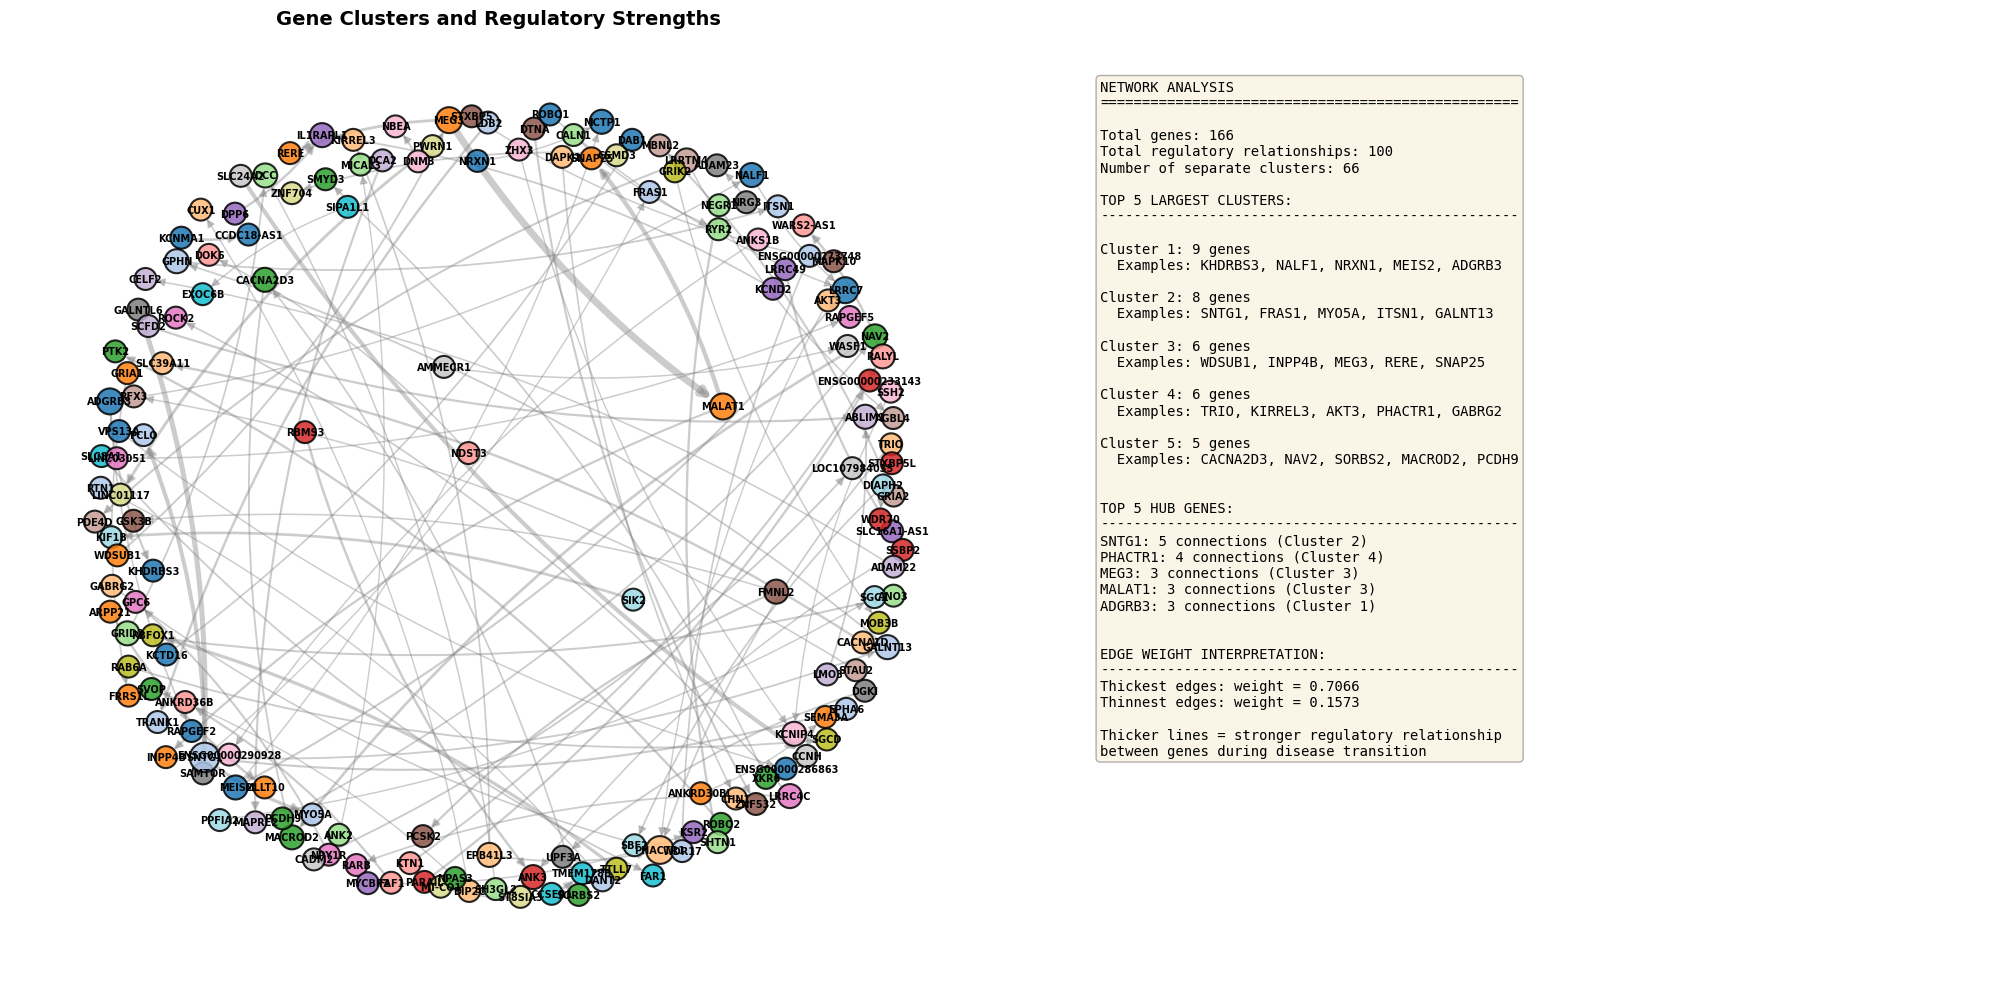


DETAILED CLUSTER ANALYSIS

Cluster 0 (9 genes):
  Hub gene: ADGRB3 with 3 connections
  All genes: ADGRB3, KHDRBS3, LRRC7, MCTP1, MEIS2, NALF1, NRXN1, RAPGEF2, ROBO1

Cluster 1 (8 genes):
  Hub gene: SNTG1 with 5 connections
  All genes: EPHA6, FRAS1, GALNT13, GPHN, ITSN1, MYO5A, PCLO, SNTG1

Cluster 2 (6 genes):
  Hub gene: MEG3 with 3 connections
  All genes: INPP4B, MALAT1, MEG3, RERE, SNAP25, WDSUB1


In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# First, we need to add weights to your edges from the OT plan
# This extracts the actual regulatory strength for each edge
top_edges_with_weights = top_edges.copy()
weights = []

for idx, row in top_edges.iterrows():
    gene_from = row['from']
    gene_to = row['to']
    
    # Find where these genes are in your gene list
    from_idx = gene_names.index(gene_from)
    to_idx = gene_names.index(gene_to)
    
    # Get the regulatory strength from the OT plan matrix
    weight = ot_plan_genes[from_idx, to_idx]
    weights.append(weight)

top_edges_with_weights['weight'] = weights

# Create the network with weights included
G = nx.from_pandas_edgelist(
    top_edges_with_weights, 
    source='from', 
    target='to', 
    edge_attr='weight',
    create_using=nx.DiGraph()
)

# Find connected components (clusters of genes that are linked together)
# For directed graphs, we use weakly connected components
# This means genes are in the same cluster if there's ANY path between them
components = list(nx.weakly_connected_components(G))
components = sorted(components, key=len, reverse=True)  # Sort by size

print(f"Found {len(components)} separate clusters in the network")
print(f"Largest cluster has {len(components[0])} genes")
print(f"Smallest cluster has {len(components[-1])} genes")

# Assign each gene to a cluster and give each cluster a color
node_to_cluster = {}
for cluster_id, component in enumerate(components):
    for node in component:
        node_to_cluster[node] = cluster_id

# Create a color map - different colors for different clusters
colormap = get_cmap('tab20')  # This gives us 20 distinct colors
node_colors = [colormap(node_to_cluster[node] % 20) for node in G.nodes()]

# Calculate node sizes based on how connected each gene is
node_degrees = dict(G.degree())
node_sizes = [node_degrees[node] * 50 + 200 for node in G.nodes()]

# Extract edge weights for visualization
edges = G.edges()
edge_weights = [G[u][v]['weight'] for u, v in edges]

# Normalize edge weights so they work well for line thickness
# The thicker the line, the stronger the regulatory relationship
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_widths = [1 + 4 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]

# Create the layout - this positions genes in 2D space
pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

# Now create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# LEFT PLOT: Colored by cluster with weighted edges
ax1.set_title('Gene Clusters and Regulatory Strengths', fontsize=14, fontweight='bold')

# Draw edges with thickness showing regulatory strength
nx.draw_networkx_edges(
    G, pos, ax=ax1,
    width=edge_widths,
    edge_color='gray',
    alpha=0.4,
    arrows=True,
    arrowsize=12,
    connectionstyle='arc3,rad=0.1',
    node_size=node_sizes
)

# Draw nodes colored by cluster
nx.draw_networkx_nodes(
    G, pos, ax=ax1,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.85,
    edgecolors='black',
    linewidths=1.5
)

# Add gene labels
nx.draw_networkx_labels(
    G, pos, ax=ax1,
    font_size=7,
    font_weight='bold'
)

ax1.axis('off')

# RIGHT PLOT: Legend and statistics
ax2.axis('off')

# Create a legend showing the top clusters
legend_text = "NETWORK ANALYSIS\n" + "="*50 + "\n\n"
legend_text += f"Total genes: {len(G.nodes())}\n"
legend_text += f"Total regulatory relationships: {len(G.edges())}\n"
legend_text += f"Number of separate clusters: {len(components)}\n\n"

legend_text += "TOP 5 LARGEST CLUSTERS:\n" + "-"*50 + "\n"
for i, component in enumerate(components[:5]):
    legend_text += f"\nCluster {i+1}: {len(component)} genes\n"
    # Show a few example genes from this cluster
    example_genes = list(component)[:5]
    legend_text += f"  Examples: {', '.join(example_genes)}\n"

legend_text += "\n\nTOP 5 HUB GENES:\n" + "-"*50 + "\n"
top_hubs = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
for gene, degree in top_hubs:
    cluster_id = node_to_cluster[gene]
    legend_text += f"{gene}: {degree} connections (Cluster {cluster_id+1})\n"

legend_text += "\n\nEDGE WEIGHT INTERPRETATION:\n" + "-"*50 + "\n"
legend_text += f"Thickest edges: weight = {max_weight:.4f}\n"
legend_text += f"Thinnest edges: weight = {min_weight:.4f}\n"
legend_text += "\nThicker lines = stronger regulatory relationship\n"
legend_text += "between genes during disease transition"

ax2.text(0.1, 0.95, legend_text, 
         transform=ax2.transAxes,
         fontsize=10,
         verticalalignment='top',
         fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Print detailed cluster analysis
print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS")
print("="*60)

for i, component in enumerate(components[:3]):  # Show top 3 clusters
    print(f"\nCluster {i} ({len(component)} genes):")
    
    # Find the most connected gene in this cluster
    cluster_degrees = {node: node_degrees[node] for node in component}
    hub_in_cluster = max(cluster_degrees, key=cluster_degrees.get)
    print(f"  Hub gene: {hub_in_cluster} with {cluster_degrees[hub_in_cluster]} connections")
    
    # Show all genes if cluster is small, or just a sample if large
    if len(component) <= 10:
        print(f"  All genes: {', '.join(sorted(component))}")
    else:
        print(f"  Sample genes: {', '.join(sorted(list(component)[:10]))}...")

In [28]:
# Sort by weight to find strongest regulatory relationships
top_edges_ranked = top_edges_with_weights.sort_values('weight', ascending=False)

# Select top-K edges (e.g., top 1000)
K = 1000
significant_edges = top_edges_ranked.head(K)
significant_edges

,from,to,weight
0,MEG3,MALAT1,0.706639
1,SAMTOR,GALNTL6,0.519615
2,MALAT1,SNAP25,0.450765
3,SLC24A2,CCNH,0.427917
4,SNTG1,PCLO,0.418588
...,...,...,...
95,NPAS3,SVOP,0.159803
96,ZHX3,KCNIP4,0.158989
97,SSH2,KCNIP4,0.158673
98,SNTG1,FRAS1,0.158195


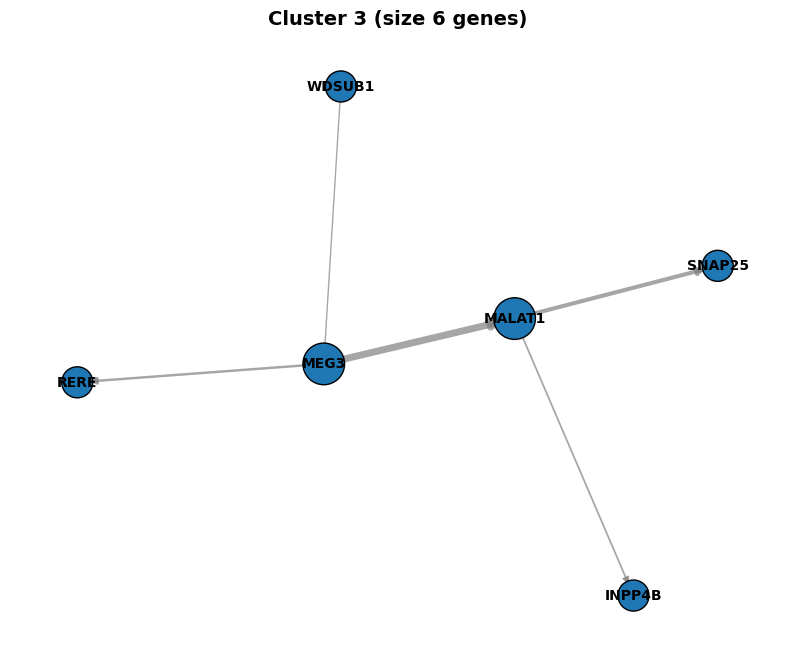

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap

# Specify cluster ID you want to plot (0-indexed)
cluster_id_to_plot = 2

# Extract nodes belonging to that cluster
cluster_nodes = [node for node, cid in node_to_cluster.items() if cid == cluster_id_to_plot]

# Induce subgraph
G_sub = G.subgraph(cluster_nodes).copy()
# Get node degrees for size scaling
node_degrees_sub = dict(G_sub.degree())
node_sizes_sub = [node_degrees_sub[node]*200 + 300 for node in G_sub.nodes()]

# Get edge weights for width scaling
edge_weights_sub = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
min_w, max_w = min(edge_weights_sub), max(edge_weights_sub)
edge_widths_sub = [1 + 4*(w - min_w)/(max_w - min_w) for w in edge_weights_sub]

# Use a single color for the cluster
colormap = get_cmap('tab10')
node_colors_sub = [colormap(0)]*len(G_sub.nodes())

# Layout
pos_sub = nx.spring_layout(G_sub, k=0.8, iterations=50, seed=42)

# Plot
plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(G_sub, pos_sub, node_color=node_colors_sub, node_size=node_sizes_sub, edgecolors='black')
nx.draw_networkx_edges(G_sub, pos_sub, width=edge_widths_sub, edge_color='gray', alpha=0.7, arrows=True)
nx.draw_networkx_labels(G_sub, pos_sub, font_size=10, font_weight='bold')
plt.title(f"Cluster {cluster_id_to_plot+1} (size {len(cluster_nodes)} genes)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


In [30]:
# Calculate degree centrality (how connected each gene is)
import networkx as nx

G = nx.from_pandas_edgelist(significant_edges, 'from', 'to', 
                            edge_attr='weight', create_using=nx.DiGraph())

# In-degree: how many genes regulate this gene (potential targets)
in_degree = dict(G.in_degree())

# Out-degree: how many genes this gene regulates (potential regulators)
out_degree = dict(G.out_degree())

# Total degree
total_degree = dict(G.degree())

# Find top hub genes
hub_genes = sorted(total_degree.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 Hub Genes:")
for gene, degree in hub_genes:
    print(f"{gene}: {degree} connections")

Top 20 Hub Genes:
SNTG1: 5 connections
PHACTR1: 4 connections
MEG3: 3 connections
MALAT1: 3 connections
ADGRB3: 3 connections
LRRC7: 3 connections
NAV2: 2 connections
MACROD2: 2 connections
ANK3: 2 connections
RALYL: 2 connections
IL1RAPL1: 2 connections
ABLIM1: 2 connections
FMNL2: 2 connections
MEIS2: 2 connections
LRRTM4: 2 connections
GRID2: 2 connections
GALNT13: 2 connections
CACNA2D3: 2 connections
GPHN: 2 connections
EPB41L3: 2 connections


,donor_id,Group_name,vireo_best_singlet,dropsift_is_cell,Neighborhood_label,Neighborhood_name,Class_label,Class_name,Subclass_label,Subclass_name,...,infection_related_death,psbulk_cells,psbulk_counts,pseudobulk_group_for_DEG,sex,age_of_onset,age_of_death,repeat_length,year_collected,disease_duration
pseudobulk_group,,,,,,,,,,,,,,,,,,,,,
SCF-18-003-STRv D1 MSN,SCF-18-003,STRv D1 MSN,SCF-18-003,True,CS20250428_NEIGH_0002,Subpallium GABA,CS20250428_CLASS_0003,CN LGE GABA,CS20250428_SUBCL_0028,STR D1 MSN,...,Yes,509.0,16004035.0,STRv D1 MSN,M,32,41.0,42.0,2018.0,9.0
SCF-22-058CF-STRv D1 MSN,SCF-22-058CF,STRv D1 MSN,SCF-22-058CF,True,CS20250428_NEIGH_0002,Subpallium GABA,CS20250428_CLASS_0003,CN LGE GABA,CS20250428_SUBCL_0028,STR D1 MSN,...,No,1015.0,28050189.0,STRv D1 MSN,F,F-control carrier,66.0,NaN,2022.0,NaN


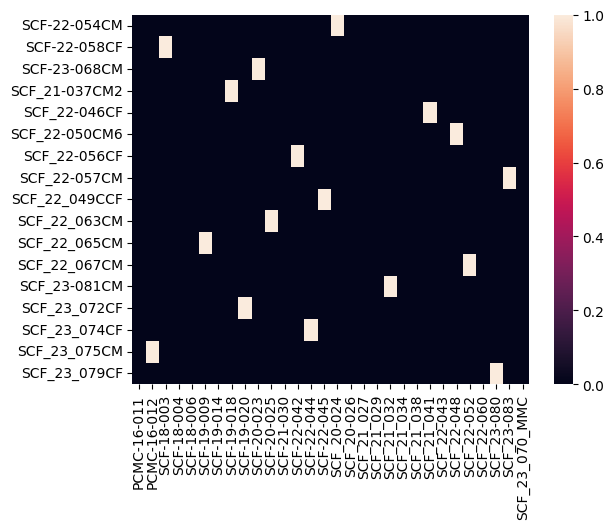

In [31]:
import seaborn as sns

sns.heatmap(ot_plan_samples, yticklabels=healthy_df.columns, xticklabels=diseased_df.columns)

adata_pb_all.obs[adata_pb_all.obs.donor_id.isin(["SCF-22-058CF", "SCF-18-003"])]

In [32]:
"TAF1" in key_genes

False